<a href="https://colab.research.google.com/github/maricelandal/food-sales-predictions/blob/main/food_sales_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Data

In [1]:
# Mount our Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libraries

In [2]:
# Imports
import numpy as np
import pandas as pd

# pre-processing functions
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

# models
from sklearn.dummy import DummyRegressor # this is for the base model which we will compare our LR model to
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

# metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn import set_config
set_config(display='diagram')



# Load Data

In [3]:
# Load Data

# file = ('/content/drive/MyDrive/Coding Dojo/Week 1/sales_prediction/sales_predictions_2023.csv')

# df = pd.read_csv(file)

# # Check first 5 rows

# df.head()

In [4]:
file = '/content/drive/MyDrive/Coding Dojo/Week 1/sales_prediction/sales_predictions_2023.csv'

df = pd.read_csv(file, usecols = lambda column: column not in ['Item_Identifier', 'Outlet_Identifier'])
df.head()

# The purpose of our model is to figure out its relationship to the randomness.
# So we exclude 'Item_Identifier', 'Outlet_Identifier' because they are irrelevant columns.

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,Low Fat,0.016047,Dairy,249.8092,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.92,Regular,0.019278,Soft Drinks,48.2692,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,17.50,Low Fat,0.016760,Meat,141.6180,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,1998,NaN,Tier 3,Grocery Store,732.3800
4,8.93,Low Fat,0.000000,Household,53.8614,1987,High,Tier 3,Supermarket Type1,994.7052


# Exploratory Data Analysis (EDA)


In [5]:
# check the shape

df.shape

# The dataset has 8,523 rows and 11 columns.

(8523, 10)

In [6]:
# or checking for rows

len(df)

# The datasset has 8,523 rows

8523

In [7]:
# or checking for columns

len(df.columns)

# The datasset has 11 columns

10

In [8]:
# check the datatype

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                7060 non-null   float64
 1   Item_Fat_Content           8523 non-null   object 
 2   Item_Visibility            8523 non-null   float64
 3   Item_Type                  8523 non-null   object 
 4   Item_MRP                   8523 non-null   float64
 5   Outlet_Establishment_Year  8523 non-null   int64  
 6   Outlet_Size                6113 non-null   object 
 7   Outlet_Location_Type       8523 non-null   object 
 8   Outlet_Type                8523 non-null   object 
 9   Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(5)
memory usage: 666.0+ KB


In [9]:
# check duplicates

df.duplicated().sum()

# The dataset has no duplicate values.

0

In [10]:
# check if there are missing values

df.isna().sum()

# There are 1,463 missing values under Item_Weight and 2,410 missing values under Outlet_Size

Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [11]:
# check statistics

df.describe()

# for numerical columns, use df.describe() - to check min, max, mean

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [12]:
# check for values of dtypes == object

dtypes = df.dtypes

object_cols = dtypes[dtypes == 'object'].index
object_cols

Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type'],
      dtype='object')

In [13]:
# check the values in each object columns using for loop to check any inconsistencies and value counts

for cols in object_cols:
  print(f'Column = {cols}')
  print(df[cols].value_counts(dropna = False))
  print('\n')

# Item_Weight and Outlet_Size value counts to check which method to use in filling in missing values
# There are irregularity or inconsitency in the column 'Item_Fat_Content'
# We should replace 'LF' and 'low fat' with 'Low Fat'
# We should also replace 'reg' with 'Regular'

Column = Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64


Column = Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64


Column = Outlet_Size
Medium    2793
NaN       2410
Small     2388
High       932
Name: Outlet_Size, dtype: int64


Column = Outlet_Location_Type
Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64


Column = Outlet_Type
Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3 

In [14]:
# check for values of dtypes == float

dtypes = df.dtypes

number_cols = dtypes[dtypes == 'float'].index
number_cols

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales'], dtype='object')

In [15]:
# check the values in each float columns using for loop

for num_cols in number_cols:
  print(f'Column = {num_cols}')
  print(df[num_cols].value_counts(dropna = False))
  print('\n')


# to check the mode of 'Item_Weight' which has missing values
# 12.15 is the Item_Weight which has the most frequent occurences (mode)

Column = Item_Weight
NaN       1463
12.150      86
17.600      82
13.650      77
11.800      76
          ... 
7.275        2
7.685        1
9.420        1
6.520        1
5.400        1
Name: Item_Weight, Length: 416, dtype: int64


Column = Item_Visibility
0.000000    526
0.076975      3
0.162462      2
0.076841      2
0.073562      2
           ... 
0.013957      1
0.110460      1
0.124646      1
0.054142      1
0.044878      1
Name: Item_Visibility, Length: 7880, dtype: int64


Column = Item_MRP
172.0422    7
170.5422    6
196.5084    6
188.1872    6
142.0154    6
           ..
97.3384     1
83.1934     1
96.6752     1
152.6682    1
75.4670     1
Name: Item_MRP, Length: 5938, dtype: int64


Column = Item_Outlet_Sales
958.7520     17
1342.2528    16
703.0848     15
1845.5976    15
1278.3360    14
             ..
4124.6310     1
6622.7126     1
1614.5650     1
5602.7070     1
2778.3834     1
Name: Item_Outlet_Sales, Length: 3493, dtype: int64




In [16]:
# check for values of dtypes == int

dtypes = df.dtypes

est_year_col = dtypes[dtypes == 'int'].index
est_year_col

# We can convert this column from int to datetime

Index(['Outlet_Establishment_Year'], dtype='object')

In [17]:
# check the values in each int columns using for loop
# replace dtype
for year_col in est_year_col:
  print(f'Column = {year_col}')
  print(df[year_col].value_counts(dropna = False))


# no inconsistency under the Column 'Outlet_Establishment_Year'

Column = Outlet_Establishment_Year
1985    1463
1987     932
1999     930
1997     930
2004     930
2002     929
2009     928
2007     926
1998     555
Name: Outlet_Establishment_Year, dtype: int64


# EDA Results

There are missing values for columns: Item_Weight (1463), Outlet_Size (2410).

There are inconsistent or irregularity in 'Item_Fat_Content' column.

We should change the datatype of Outlet_Establishment_Year from int to datetime.

# Data Cleaning

#### Fill the missing values

We will do this step after the train test split using Simple Imputer

In [18]:
# # Imputing Missing Data Using sklearn (sklearn simple imputation has algorithm)


# df['Item_Weight'].fillna(12.150, inplace=True)
# # df['Item_Weight'].fillna(12.857645, inplace=True)


# # For 'Item_Weight', the mean (12.85) is slightly higher than the mode (12.15)
# # Will use the mode to fill the missing values (comprised 17% of total, derived using count of missing/total rows) #########
# # Will use the mean to fill the missing values (comprised 17% of total, derived using count of missing/total rows)
# # The 17% missing values under 'Item_Weight' should be imputed (dropping them is not advisable)


In [19]:
# # Under 'Outlet_Size' column, total missing values is 2,410 (28% of total)

# # Medium    2793
# # NaN       2410
# # Small     2388
# # High       932

# df['Outlet_Size'].fillna('Medium', inplace = True)

# # The most frequent value under 'Outlet_Size' is medium which consist of 2,793 (33% of total)
# # The next most frequesnt value is Small, which consist of 2,388 (28% of total)
# # The item which has least occurence is High which consist of 932 (11% of total)
# # We can use the mode (most frequent value) to fill the missing values for categorical data

In [20]:
# check if again if there are still missing values

df.isna().sum()

# After simple imputation (filling in the 'Item_Weight' with average weight), there are no more missing values
# After simple imputation (filling in the 'Outlet_Size' with Medium, which has most frequent occurences), there are no more missing values

Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

#### Fix the inconsistent data under 'Item_Fat_Content'

In [21]:
# There are irregularity or inconsitency in the column 'Item_Fat_Content'

df['Item_Fat_Content'].replace('LF', 'Low Fat', inplace=True)

# We should replace 'LF' and 'low fat' with 'Low Fat'

In [22]:
# We should replace 'low fat' with 'Low Fat'

df['Item_Fat_Content'].replace('low fat', 'Low Fat', inplace=True)

In [23]:
# We should also replace 'reg' with 'Regular'

df['Item_Fat_Content'].replace('reg', 'Regular', inplace=True)

# check corrections on 'Item_Fat_Content'

df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

#### Change the 'Outlet_Establishment_Year' datatype from int to datetime

In [24]:
# change date to datatype

df['Outlet_Establishment_Year'] = pd.to_datetime(df['Outlet_Establishment_Year'])

# check corrections on date datatype

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Item_Weight                7060 non-null   float64       
 1   Item_Fat_Content           8523 non-null   object        
 2   Item_Visibility            8523 non-null   float64       
 3   Item_Type                  8523 non-null   object        
 4   Item_MRP                   8523 non-null   float64       
 5   Outlet_Establishment_Year  8523 non-null   datetime64[ns]
 6   Outlet_Size                6113 non-null   object        
 7   Outlet_Location_Type       8523 non-null   object        
 8   Outlet_Type                8523 non-null   object        
 9   Item_Outlet_Sales          8523 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(5)
memory usage: 666.0+ KB


# Data Visualization

## Univariate Exploratory Visualization

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

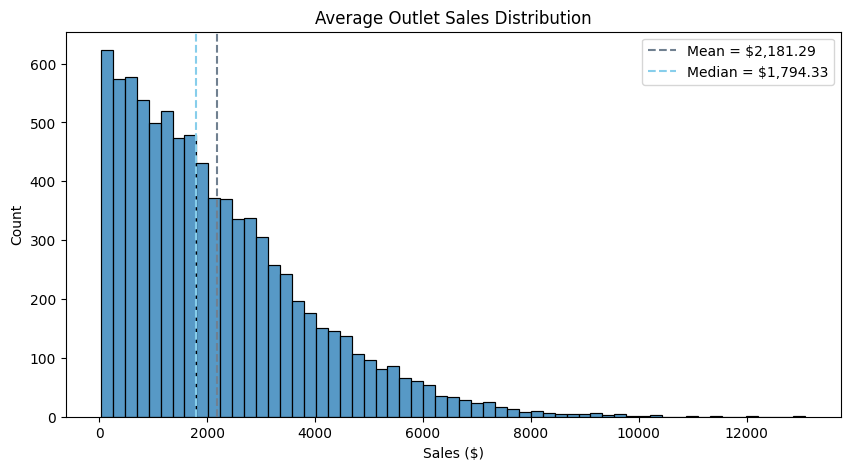

In [26]:
# Histogram of Average Outlet Sales

## Make a larger fig/ax before plotting
fig, ax = plt.subplots(figsize = (10, 5))

## Plot histogram
sns.histplot(data=df, x=round(df['Item_Outlet_Sales']), ax=ax)
ax.set(title="Average Outlet Sales Distribution")

## Annotating mean and median
mean_sales = df['Item_Outlet_Sales'].mean()
ax.axvline(mean_sales,
           color='slategray',
           ls='--',
           label=f"Mean = ${mean_sales:,.2f}")

med_sales = df['Item_Outlet_Sales'].median()
ax.axvline(med_sales,
           color='skyblue',
           ls='--',
           label=f"Median = ${med_sales:,.2f}")

# Labels and Legend
ax.set(xlabel="Sales ($)")
ax.legend();

fig;

The data suggest that the distribution of average outlet sales is positively skewed. The mean ($2,181.29) is greater than 0, the hump is on the left while it has a long tail on the right.

The concentration of average outlet sales is in the 75th percentile (Q3) - middle value between median and the highest value of dataset.

There are several outliers after the max of value of dataset as shown by its long tail.

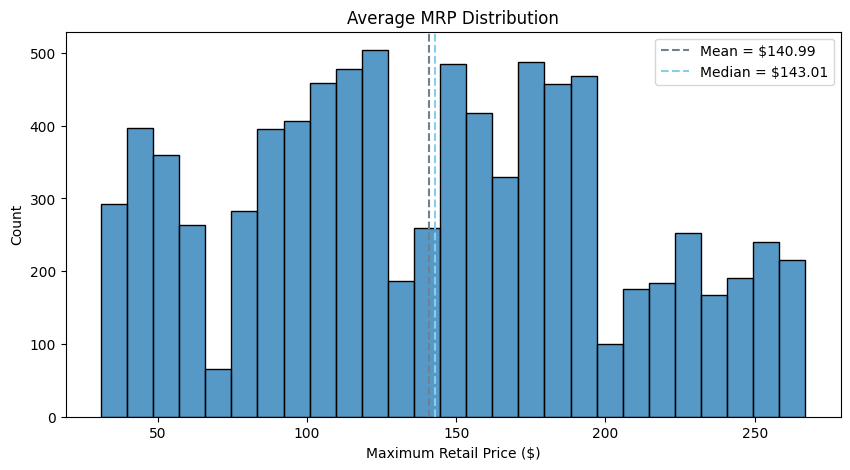

In [27]:
# Histogram of Item_MRP (Maximum Retail Price)

## Make a larger fig/ax before plotting
fig, ax = plt.subplots(figsize = (10, 5))

## Plot histogram
sns.histplot(data=df, x=round(df['Item_MRP']), ax=ax)
ax.set(title="Average MRP Distribution")

## Annotating mean and median
mean_mrp = df['Item_MRP'].mean()
ax.axvline(mean_mrp,
           color='slategray',
           ls='--',
           label=f"Mean = ${mean_mrp:,.2f}")

med_mrp = df['Item_MRP'].median()
ax.axvline(med_mrp,
           color='skyblue',
           ls='--',
           label=f"Median = ${med_mrp:,.2f}")

# Labels and Legend
ax.set(xlabel="Maximum Retail Price ($)")
ax.legend();

fig;

The data suggest that average MRP has a normal distribution. The data is symmetric and has no skew. Average MRP is close to the middle value of the dataset.

The concentration is at the mean; cluster of data points toward the middle of the range.

There are no outliers (no data points outside the horizonal black line (min and max of dataset).

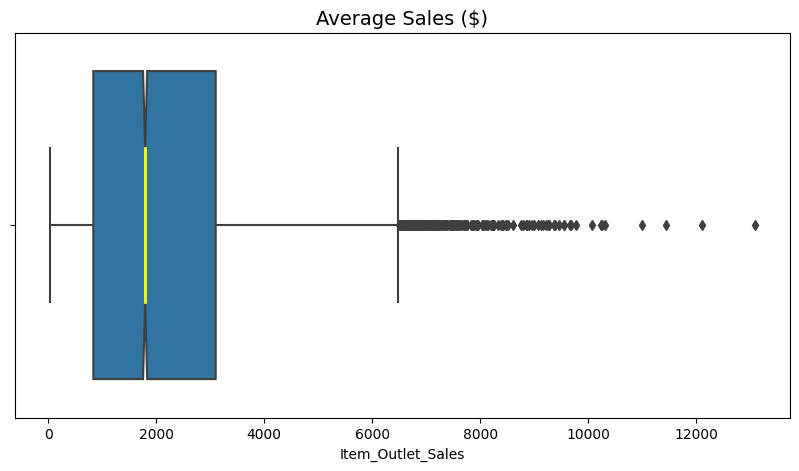

In [28]:
# seaborn
# Create figure
fig, ax = plt.subplots(figsize=(10, 5))

# Set the title
ax.set_title('Average Sales ($)', fontsize=14)

# Label and Notch
sns.boxplot(data = df,
            x = 'Item_Outlet_Sales',
            notch = True,
            medianprops=dict(linestyle='-',
            linewidth=2,
            color='Yellow'));

The data suggest that the distribution for outlet sales is positively skewed. The mean is greater than 0, hump is on the left while the tail extends to the right.

There are also several outliers as shown by data points outside the maximum value of the dataset.

<ipython-input-29-032342f55c84>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.drop(columns = 'Item_Type').corr()


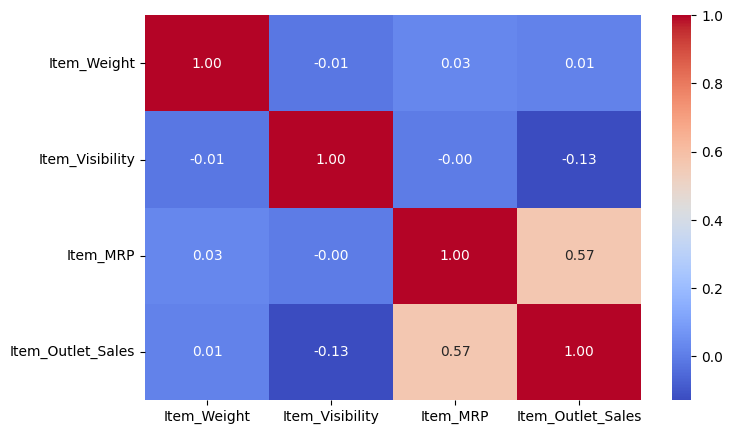

In [29]:
# heatmap
# create a var and drop ReAdmis is this was id to be irrelevant
corr = df.drop(columns = 'Item_Type').corr()

# plot the heatmap
plt.figure(figsize = (8,5))
sns.heatmap(corr, cmap = 'coolwarm', annot = True, fmt = '.2f');

# correlation bet features
# correlation table
# 0.30 - 0.50 = there is a weak + correlation
# 0.51 - 0.70 = there is a moderate + correlation
# 0.71 - 0.90 = there is a strong + correlation
# 0.91 - 1.00 = there is vstrong + correlation (perfect)

Correlation observations:

There is a moderate positive correlation between Item_MRP and Item_Outlet_Sales (0.57)

As the maximum retail price (MRP) goes up, sales also goes up; price and quantity are a function of sales so it is rational that they are positively correlated.

## Multivariate Exploratory Visualization

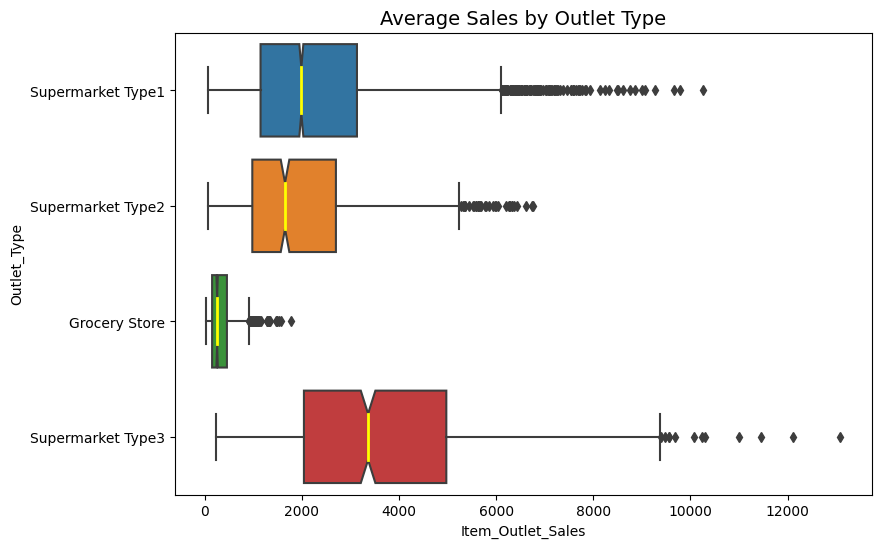

In [30]:
# Seaborn
# Create figure
fig, ax = plt.subplots(figsize=(9, 6))

# Set the title
ax.set_title('Average Sales by Outlet Type', fontsize=14)

# Labels and Notch
sns.boxplot(data = df,
            y = 'Outlet_Type',
            x = 'Item_Outlet_Sales',
            notch = True,
            medianprops=dict(linestyle='-',
            linewidth=2,
            color='Yellow'));

plt.show();

The data suggest that the distribution for all outlet type is positively skewed. The mean is greater than 0, hump is on the left while the tail extends to the right.

There are also several outliers as shown by data points outside the maximum value of the dataset.

Highest sales came from Supermarket 3 as shown by the range of sales generated from that outlet.

In [31]:
# Creat variable to group average sales by item type

avg_item_sales = df.groupby('Item_Type')['Item_Outlet_Sales'].mean()
avg_item_sales

Item_Type
Baking Goods             1952.971207
Breads                   2204.132226
Breakfast                2111.808651
Canned                   2225.194904
Dairy                    2232.542597
Frozen Foods             2132.867744
Fruits and Vegetables    2289.009592
Hard Drinks              2139.221622
Health and Hygiene       2010.000265
Household                2258.784300
Meat                     2158.977911
Others                   1926.139702
Seafood                  2326.065928
Snack Foods              2277.321739
Soft Drinks              2006.511735
Starchy Foods            2374.332773
Name: Item_Outlet_Sales, dtype: float64

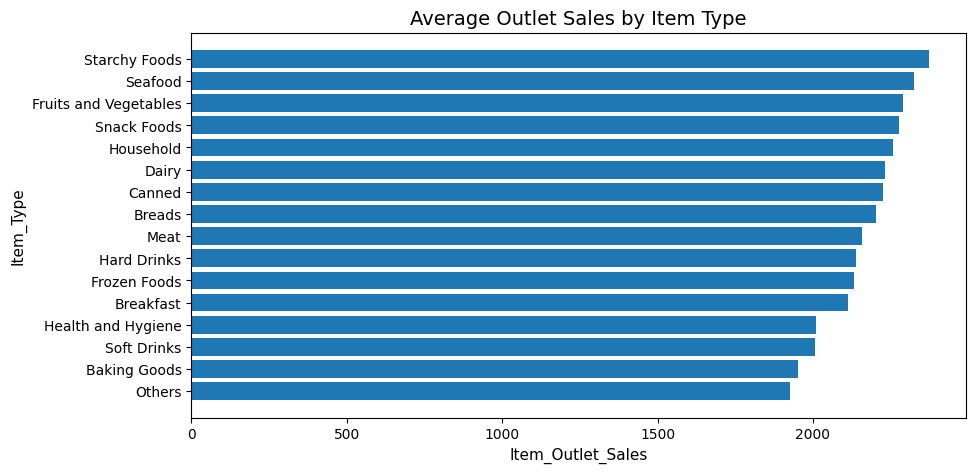

In [32]:
# use the variable to sort values by Item Type
avg_item_sales = avg_item_sales.sort_values()

# Plot the Figure
plt.figure(figsize=(10,5))

# Horixontal Bar Chart
plt.barh(avg_item_sales.index, avg_item_sales.values)

# Title and Labels
plt.ylabel('Item_Type', fontsize=11)
plt.xlabel('Item_Outlet_Sales', fontsize=11)
plt.title("Average Outlet Sales by Item Type", fontsize=14)

plt.show();

The data suggest that among the items being sold, Starchy Foods has the highest sales, followed by Seafood and Fruits and Vegetables.

Lowest sales came from Other Items, Baking Goods and Soft Drinks.

In [33]:
# Creat variable to group average sales by outlet type

avg_type_sales = df.groupby('Outlet_Type')['Item_Outlet_Sales'].mean()
avg_type_sales

Outlet_Type
Grocery Store         339.828500
Supermarket Type1    2316.181148
Supermarket Type2    1995.498739
Supermarket Type3    3694.038558
Name: Item_Outlet_Sales, dtype: float64

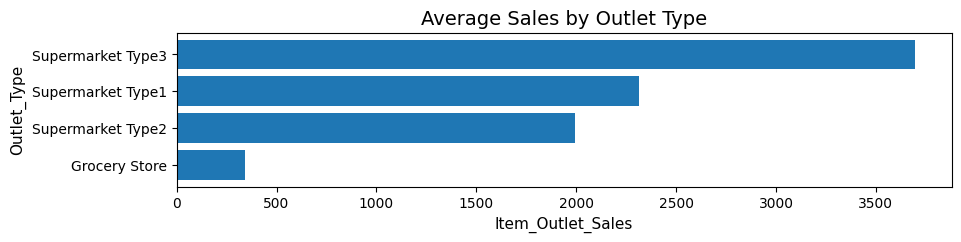

In [34]:
# use the variable to sort values by Outlet Type
avg_type_sales = avg_type_sales.sort_values()

# Plot the Figure
plt.figure(figsize=(10,2))

# Horixontal Bar Chart
plt.barh(avg_type_sales.index, avg_type_sales.values)

# Title and Labels
plt.ylabel('Outlet_Type', fontsize=11)
plt.xlabel('Item_Outlet_Sales', fontsize=11)
plt.title("Average Sales by Outlet Type", fontsize=14)

plt.show();

The data suggest that among the four outlet types, Supermarket Type 3 generates the highest sales while the least sales-generating is Grocery Store.

It is rational that in terms of wide selection of products, Supermarket is bigger in size and higher foot traffic leads to higher sales; hence, more sales are generated in supermarket compared to grocery store.

In [35]:
# Creat variable to group average sales by outlet size

avg_outlet_sales = df.groupby('Outlet_Size')['Item_Outlet_Sales'].mean()
avg_outlet_sales

Outlet_Size
High      2298.995256
Medium    2681.603542
Small     1912.149161
Name: Item_Outlet_Sales, dtype: float64

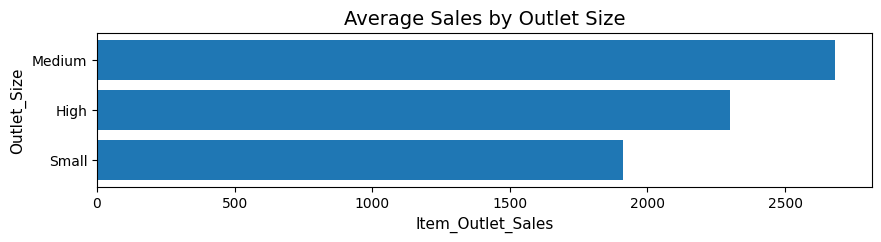

In [36]:
# use the variable to sort values by Outlet Size
avg_outlet_sales = avg_outlet_sales.sort_values()

# Plot the Figure
plt.figure(figsize=(10,2))

# Horixontal Bar Chart
plt.barh(avg_outlet_sales.index, avg_outlet_sales.values)

# Title and Labels
plt.ylabel('Outlet_Size', fontsize=11)
plt.xlabel('Item_Outlet_Sales', fontsize=11)
plt.title("Average Sales by Outlet Size", fontsize=14)

plt.show();

The data suggest that higher sales are generated from High and Medium Outlet Size.

The data also suggest that size and type of outlets determine potential sales. As shown in previous chart, Supermarket (bigger in terms of size compared to grocery store) generate higher sales.

In [37]:
# Creat variable to group average sales by outlet location type

avg_loc_sales = df.groupby('Outlet_Location_Type')['Item_Outlet_Sales'].mean()
avg_loc_sales

Outlet_Location_Type
Tier 1    1876.909159
Tier 2    2323.990559
Tier 3    2279.627651
Name: Item_Outlet_Sales, dtype: float64

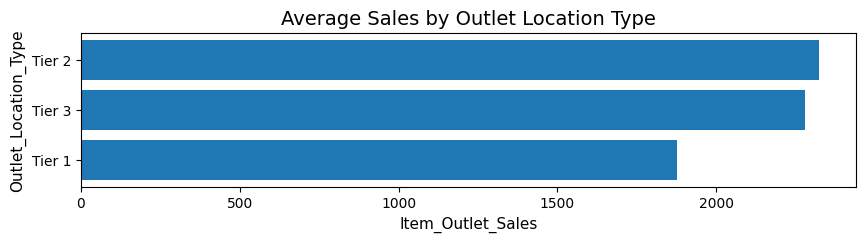

In [38]:
# use the variable to sort values by Outlet Type
avg_loc_sales = avg_loc_sales.sort_values()

# Plot the Figure
plt.figure(figsize=(10,2))

# Horixontal Bar Chart
plt.barh(avg_loc_sales.index, avg_loc_sales.values)

# Title and Labels
plt.ylabel('Outlet_Location_Type', fontsize=11)
plt.xlabel('Item_Outlet_Sales', fontsize=11)
plt.title("Average Sales by Outlet Location Type", fontsize=14)

plt.show();

The data suggest that more sales are generated from Tier 2 followed by Tier 3 Outlet Location.

Among the three outlet location, Tier 1 generated the lowest sales.

In [39]:
# filter data (top 5)

item_type_top5 = df.groupby('Item_Type')['Item_Outlet_Sales'].mean().sort_values(ascending = False).head(5)
item_type_top5

Item_Type
Starchy Foods            2374.332773
Seafood                  2326.065928
Fruits and Vegetables    2289.009592
Snack Foods              2277.321739
Household                2258.784300
Name: Item_Outlet_Sales, dtype: float64

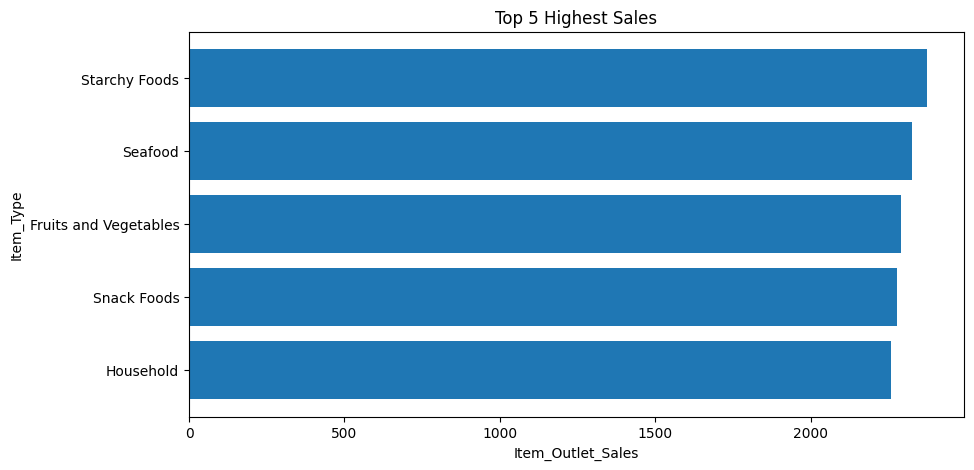

In [40]:
# use the variable to sort values by top 5 Item Type
item_type_top5 = item_type_top5.sort_values()

# Plot the horizontal bar sorted from highest to lowest
plt.figure(figsize=(10,5))
plt.barh(item_type_top5.index, item_type_top5.values)

# Labels and Title
plt.ylabel('Item_Type')
plt.xlabel('Item_Outlet_Sales')
plt.title("Top 5 Highest Sales")

plt.show();

Filter the top 5 so we can only focus on the items with the highest sales: starchy foods, seafood, fruits and vegetables, snack foods, household.

In [41]:
Top5_Item_List = ['Starchy Foods', 'Seafood', 'Fruits and Vegetables', 'Snack Foods', 'Household']

filtered_top5_df = df[df['Item_Type'].isin(Top5_Item_List)]
filtered_top5_df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
3,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,1970-01-01 00:00:00.000001998,NaN,Tier 3,Grocery Store,732.3800
4,8.93,Low Fat,0.000000,Household,53.8614,1970-01-01 00:00:00.000001987,High,Tier 3,Supermarket Type1,994.7052
6,13.65,Regular,0.012741,Snack Foods,57.6588,1970-01-01 00:00:00.000001987,High,Tier 3,Supermarket Type1,343.5528
7,NaN,Low Fat,0.127470,Snack Foods,107.7622,1970-01-01 00:00:00.000001985,Medium,Tier 3,Supermarket Type3,4022.7636
10,11.80,Low Fat,0.000000,Fruits and Vegetables,45.5402,1970-01-01 00:00:00.000001999,Medium,Tier 1,Supermarket Type1,1516.0266


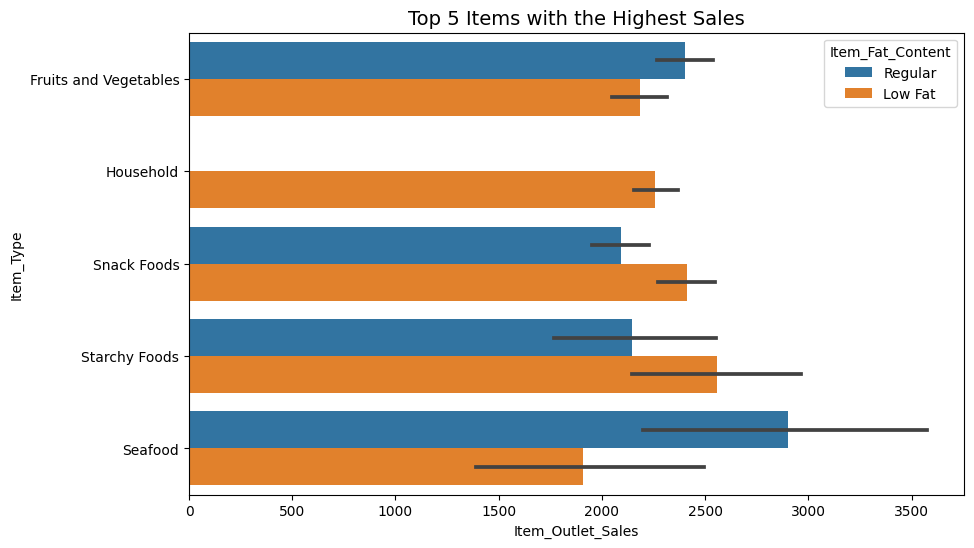

In [42]:
# Outlet Sales by Item_Type and Item_Fat_Content
# Seaborn
fig, ax = plt.subplots(figsize=(10, 6))

# Create barplot, set x and y and hue
# plt.barh(avg_item_sales.index, avg_item_sales.values)
sns.barplot(data=filtered_top5_df, x = 'Item_Outlet_Sales', y = 'Item_Type', hue = 'Item_Fat_Content')

# Set Title
ax.set_title('Top 5 Items with the Highest Sales', fontsize=14)

plt.show();

The data suggest that among the top 5 items with highest sales, Seafood with regular fat content has better sales performance than Seafood with low fat content.

In [43]:
# filter data (bottom 5)

item_type_bottom5 = df.groupby('Item_Type')['Item_Outlet_Sales'].mean().sort_values(ascending = True).head(5)
item_type_bottom5

Item_Type
Others                1926.139702
Baking Goods          1952.971207
Soft Drinks           2006.511735
Health and Hygiene    2010.000265
Breakfast             2111.808651
Name: Item_Outlet_Sales, dtype: float64

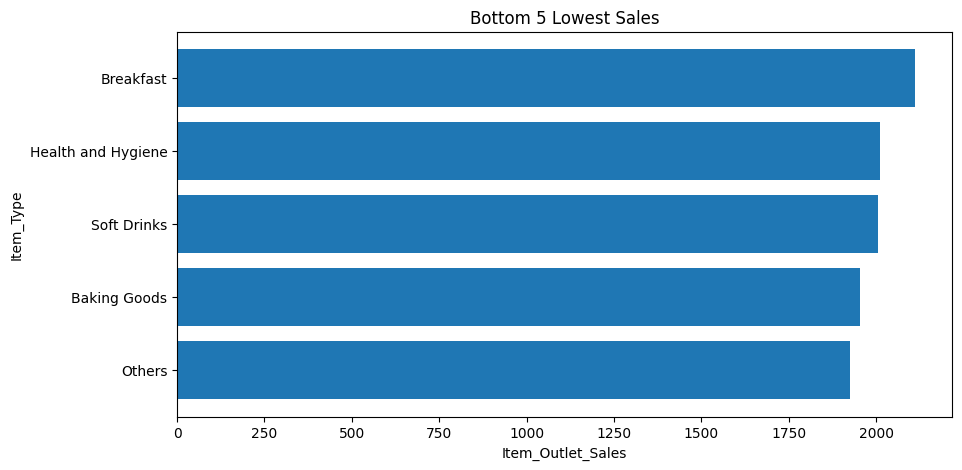

In [44]:
# use the variable to sort values by bottom 5 Item Type
item_type_bottom5 = item_type_bottom5.sort_values(ascending = True)

# Plot the horizontal bar sorted from highest to lowest
plt.figure(figsize=(10,5))
plt.barh(item_type_bottom5.index, item_type_bottom5.values)

# Labels and Title
plt.ylabel('Item_Type')
plt.xlabel('Item_Outlet_Sales')
plt.title("Bottom 5 Lowest Sales")

plt.show();

Filter the bottom 5 so we can only focus on the items with the lowest sales: others, baking goods, soft drinks, health and hygiene, breakfast.

In [45]:
Bottom5_Item_List = ['Others', 'Baking Goods', 'Soft Drinks', 'Health and Hygiene', 'Breakfast']

filtered_bottom5_df = df[df['Item_Type'].isin(Bottom5_Item_List)]
filtered_bottom5_df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
1,5.920,Regular,0.019278,Soft Drinks,48.2692,1970-01-01 00:00:00.000002009,Medium,Tier 3,Supermarket Type2,443.4228
5,10.395,Regular,0.000000,Baking Goods,51.4008,1970-01-01 00:00:00.000002009,Medium,Tier 3,Supermarket Type2,556.6088
15,9.000,Regular,0.069089,Breakfast,56.3614,1970-01-01 00:00:00.000001997,Small,Tier 1,Supermarket Type1,1547.3192
16,11.800,Low Fat,0.008596,Health and Hygiene,115.3492,1970-01-01 00:00:00.000002009,Medium,Tier 3,Supermarket Type2,1621.8888
17,9.000,Regular,0.069196,Breakfast,54.3614,1970-01-01 00:00:00.000001999,Medium,Tier 1,Supermarket Type1,718.3982


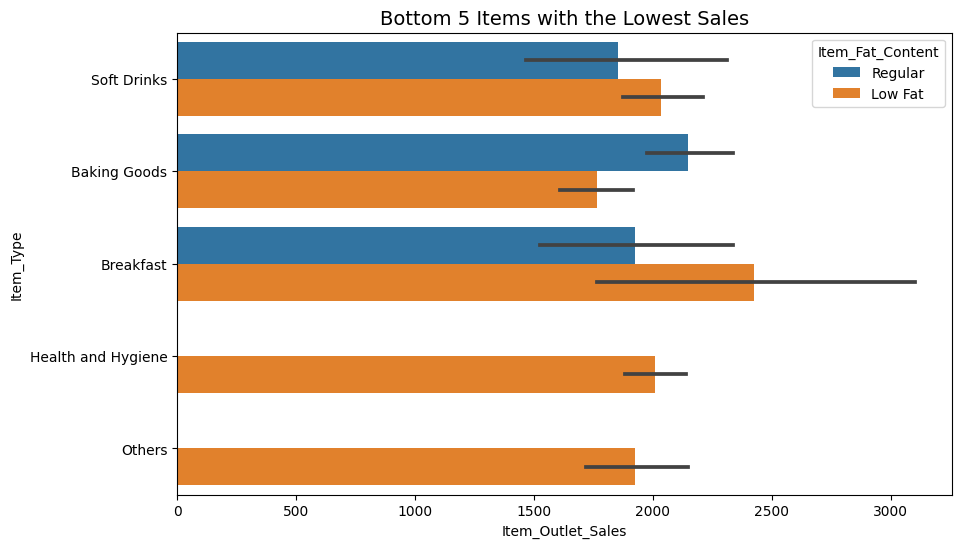

In [46]:
# Outlet Sales by Item_Type and Item_Fat_Content
# Seaborn
fig, ax = plt.subplots(figsize=(10, 6))

# Create barplot, set x and y and hue
# plt.barh(avg_item_sales.index, avg_item_sales.values)
sns.barplot(data=filtered_bottom5_df, x = 'Item_Outlet_Sales', y = 'Item_Type', hue = 'Item_Fat_Content')

# Set Title
ax.set_title('Bottom 5 Items with the Lowest Sales', fontsize=14)

plt.show();

The data suggest that sales of breakfast and softdrinks (which are ranked 5th and 3rd among the items with lowest sales, respectively) with low fat are much higher than if they have regular fat content.

Others which is ranked last among the bottom 5 items with lowest sales are sold with low fat content only, same with Health and Hygiene.

This further suggest that fat content in the item type is not posively correlated with the sales performance of the items as also shown in the heatmap (no correlation).


# ML Steps

Split the data (X, y and train, test)

Instantiate the Transformers and column selectors

Create numeric preprocessing pipeline and categorical preprocessing pipeline

Combine pipelines using column transformer

Fit preprocessor on X_train

Transform both X_train and X_test

(Optional) convert processed X_train back to a dataframe.

In [47]:
# check statistics
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,2181.288914
std,4.643456,0.051598,62.275067,1706.499616
min,4.555000,0.000000,31.290000,33.290000
25%,8.773750,0.026989,93.826500,834.247400
50%,12.600000,0.053931,143.012800,1794.331000
75%,16.850000,0.094585,185.643700,3101.296400
max,21.350000,0.328391,266.888400,13086.964800


In [48]:
# check using zscore
from scipy import stats

# create a var that includes only numeric cols
cols_to_check = df.select_dtypes(include = [np.number]).columns

# create a loop that detects outliers using the zscore
for column in cols_to_check:

  # calculate zscore for the col
  z_scores = np.abs(stats.zscore(df[column]))

  # find the indices where the zscore is > 3
  outlier_indices = np.where(z_scores > 3)

  # return the actual outlier values using the indices
  outlier_values = df[column].iloc[outlier_indices]

  # return the outliers and their indices
  print(f'Outliers in {column}: \n', outlier_values)

Outliers in Item_Weight: 
 Series([], Name: Item_Weight, dtype: float64)
Outliers in Item_Visibility: 
 49      0.255395
83      0.293418
108     0.278974
174     0.291865
434     0.264125
          ...   
8194    0.299098
8215    0.279887
8273    0.297313
8345    0.266397
8432    0.227261
Name: Item_Visibility, Length: 95, dtype: float64
Outliers in Item_MRP: 
 Series([], Name: Item_MRP, dtype: float64)
Outliers in Item_Outlet_Sales: 
 130     7968.2944
145     7370.4060
276     7452.9652
304     7696.6480
333     9267.9360
          ...    
7930    9227.9880
8039    8994.9580
8201    9390.4432
8245    7549.5062
8447    7588.1226
Name: Item_Outlet_Sales, Length: 90, dtype: float64


In [49]:
diff = (df.shape[0] - df.dropna().shape[0])

In [50]:
diff / df.shape[0]

0.4544174586413235

## Define features (X) and target (y)

In [51]:
# select target vector y and features matrix X
y = df['Item_Outlet_Sales']
X = df.drop(columns = 'Item_Outlet_Sales')

## Train test split the data to prepare for ML

In [52]:
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42, test_size = .3)

In [53]:
# select only object columns
# create a var that includes only object cols
categoricals = X_train.select_dtypes(include='object')

# check value counts for each object column
for col in categoricals.columns:
  print(col)
  print(categoricals[col].value_counts(), '\n')

Item_Fat_Content
Low Fat    3860
Regular    2106
Name: Item_Fat_Content, dtype: int64 

Item_Type
Fruits and Vegetables    905
Snack Foods              835
Household                648
Frozen Foods             591
Dairy                    474
Canned                   450
Baking Goods             438
Health and Hygiene       365
Soft Drinks              305
Meat                     275
Hard Drinks              162
Breads                   159
Others                   124
Starchy Foods            116
Breakfast                 80
Seafood                   39
Name: Item_Type, dtype: int64 

Outlet_Size
Medium    1960
Small     1667
High       649
Name: Outlet_Size, dtype: int64 

Outlet_Location_Type
Tier 3    2367
Tier 2    1957
Tier 1    1642
Name: Outlet_Location_Type, dtype: int64 

Outlet_Type
Supermarket Type1    3893
Grocery Store         744
Supermarket Type3     668
Supermarket Type2     661
Name: Outlet_Type, dtype: int64 



## Identify each feature as numerical, ordinal, or nominal

#### numerical : 'Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales'
#### ordinal : 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'
#### nominal : 'Item_Fat_Content', 'Item_Type'


## Instantiate Transformers

In [54]:
# these are transformers from scikit-learn
# scaler
scaler = StandardScaler()
scaler2 = StandardScaler()

# one-hot encoder
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

# imputer
mean_imputer = SimpleImputer(strategy='mean')
freq_imputer = SimpleImputer(strategy='most_frequent')
missing_imputer = SimpleImputer(strategy='constant', fill_value='Missing')

## Ordinal Encoder

In [55]:
# create a list
outlet_size_labels = ['Small','Medium','High']
oultet_loc_type_labels = ['Tier 1', 'Tier 2','Tier 3']
oultet_type_labels = ['Grocery Store', 'Supermarket Type1','Supermarket Type2','Supermarket Type3']

# create a var for these lists
ordered_labels = [outlet_size_labels, oultet_loc_type_labels, oultet_type_labels]
ordered_labels

[['Small', 'Medium', 'High'],
 ['Tier 1', 'Tier 2', 'Tier 3'],
 ['Grocery Store',
  'Supermarket Type1',
  'Supermarket Type2',
  'Supermarket Type3']]

In [56]:
# instantitate encode
ordinal_enc = OrdinalEncoder(categories=ordered_labels)

## Create a Pipeline for Numeric Data and a Pipeline for Categorical Data

In [57]:
# nominal data -> imputer, one-hot encode
nom_pipe = make_pipeline(missing_imputer, ohe)

# ordinal data -> imputer, ordinal encoding, scaling
ord_pipe = make_pipeline(freq_imputer, ordinal_enc, scaler2)

# numeric data -> imputer, scaler
num_pipe = make_pipeline(mean_imputer, scaler)

## Create Tuples to Pair Pipelines with Columns

In [58]:
# select the column corresponding to the type of data
ordinal_cols = ['Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']
nominal_col = ['Item_Fat_Content', 'Item_Type']
num_selector = make_column_selector(dtype_include='number')

# pairing of pipeline and the corresponding columns
nom_tuple = (nom_pipe, ['Item_Fat_Content', 'Item_Type'])
ord_tuple = (ord_pipe, ordinal_cols)
num_tuple = (num_pipe, num_selector)

## Create Column Transformer to Apply Different Preprocessing to Different Columns

In [59]:
preprocessor = make_column_transformer(ord_tuple, num_tuple, nom_tuple, remainder='drop')

## Fit the Column Transformer on the Training Data

In [60]:
preprocessor.fit(X_train)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Small',
                                                                              'Medium',
                                                                              'High'],
                                                                             ['Tier '
                                                                              '1',
                                                                              'Tier '
                                                                              '2',
                                                                              'Tier '
                                                                              '3'],
                                                                             ['Grocery '
                                                                              'Store',
                                                                              'Supermarket '
                                                                              'Type1',
                                                                              'Supermarket '
                                                                              'Type2',
                                                                              'Supermarket '
                                                                              'Type3']])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Ou...
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7e00acaa2e30>),
                                ('pipeline-3',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='Missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['Item_Fat_Content', 'Item_Type'])])

## Transform Both Training and Testing Data

In [61]:
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

## Check the Result

In [62]:
X_train_processed

array([[ 0.28475182,  1.08362706, -1.51340146, ...,  0.        ,
         0.        ,  0.        ],
       [-1.38403932, -1.38342848, -0.26268071, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.28475182,  1.08362706,  2.2387608 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.28475182, -0.14990071, -0.26268071, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.28475182, -0.14990071, -0.26268071, ...,  1.        ,
         0.        ,  0.        ],
       [-1.38403932, -1.38342848, -0.26268071, ...,  0.        ,
         0.        ,  0.        ]])

## (Optional) Convert Training Data to Data Frame and Add Column Names

In [63]:
preprocessor.named_transformers_

{'pipeline-1': Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                 ('ordinalencoder',
                  OrdinalEncoder(categories=[['Small', 'Medium', 'High'],
                                             ['Tier 1', 'Tier 2', 'Tier 3'],
                                             ['Grocery Store',
                                              'Supermarket Type1',
                                              'Supermarket Type2',
                                              'Supermarket Type3']])),
                 ('standardscaler', StandardScaler())]),
 'pipeline-2': Pipeline(steps=[('simpleimputer', SimpleImputer()),
                 ('standardscaler', StandardScaler())]),
 'pipeline-3': Pipeline(steps=[('simpleimputer',
                  SimpleImputer(fill_value='Missing', strategy='constant')),
                 ('onehotencoder',
                  OneHotEncoder(handle_unknown='ignore', sparse=False,
                                sparse_ou

In [64]:
# get transformed column names
ohe = preprocessor.named_transformers_['pipeline-3']['onehotencoder']

In [65]:
# display feature names taken from ohe
nom_feature_names = ohe.get_feature_names_out(nominal_col)
nom_feature_names

array(['Item_Fat_Content_Low Fat', 'Item_Fat_Content_Regular',
       'Item_Type_Baking Goods', 'Item_Type_Breads',
       'Item_Type_Breakfast', 'Item_Type_Canned', 'Item_Type_Dairy',
       'Item_Type_Frozen Foods', 'Item_Type_Fruits and Vegetables',
       'Item_Type_Hard Drinks', 'Item_Type_Health and Hygiene',
       'Item_Type_Household', 'Item_Type_Meat', 'Item_Type_Others',
       'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods'], dtype=object)

In [66]:
# create a final col name list that includes ord features + num features + ohe features
final_cols = ordinal_cols + num_selector(X_train) + list(nom_feature_names)
final_cols

['Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type',
 'Item_Weight',
 'Item_Visibility',
 'Item_MRP',
 'Item_Fat_Content_Low Fat',
 'Item_Fat_Content_Regular',
 'Item_Type_Baking Goods',
 'Item_Type_Breads',
 'Item_Type_Breakfast',
 'Item_Type_Canned',
 'Item_Type_Dairy',
 'Item_Type_Frozen Foods',
 'Item_Type_Fruits and Vegetables',
 'Item_Type_Hard Drinks',
 'Item_Type_Health and Hygiene',
 'Item_Type_Household',
 'Item_Type_Meat',
 'Item_Type_Others',
 'Item_Type_Seafood',
 'Item_Type_Snack Foods',
 'Item_Type_Soft Drinks',
 'Item_Type_Starchy Foods']

In [67]:
# create a dataframe using X_train_processed and the column names
X_train_output = pd.DataFrame(X_train_processed, columns = final_cols)
X_train_output.head()

,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Weight,Item_Visibility,Item_MRP,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,...,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods
0,0.284752,1.083627,-1.513401,-1.237957,1.606681,-0.401895,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.384039,-1.383428,-0.262681,1.616571,-1.008442,-0.619284,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.284752,1.083627,2.238761,0.000000,-0.227068,-0.202535,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.284752,-0.149901,-0.262681,1.521657,1.028038,1.290187,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.953543,1.083627,-0.262681,1.284373,0.515355,0.686853,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
X_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
1921,7.72,Regular,0.147904,Fruits and Vegetables,116.6466,1970-01-01 00:00:00.000001998,NaN,Tier 3,Grocery Store
655,19.75,Low Fat,0.014301,Household,103.0332,1970-01-01 00:00:00.000001997,Small,Tier 1,Supermarket Type1
2229,NaN,Regular,0.054221,Breads,129.1310,1970-01-01 00:00:00.000001985,Medium,Tier 3,Supermarket Type3
2537,19.35,Low Fat,0.118342,Snack Foods,222.6088,1970-01-01 00:00:00.000002002,NaN,Tier 2,Supermarket Type1
3528,18.35,Regular,0.092150,Frozen Foods,184.8266,1970-01-01 00:00:00.000001987,High,Tier 3,Supermarket Type1


In [69]:
X_train_output.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5966 entries, 0 to 5965
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Outlet_Size                      5966 non-null   float64
 1   Outlet_Location_Type             5966 non-null   float64
 2   Outlet_Type                      5966 non-null   float64
 3   Item_Weight                      5966 non-null   float64
 4   Item_Visibility                  5966 non-null   float64
 5   Item_MRP                         5966 non-null   float64
 6   Item_Fat_Content_Low Fat         5966 non-null   float64
 7   Item_Fat_Content_Regular         5966 non-null   float64
 8   Item_Type_Baking Goods           5966 non-null   float64
 9   Item_Type_Breads                 5966 non-null   float64
 10  Item_Type_Breakfast              5966 non-null   float64
 11  Item_Type_Canned                 5966 non-null   float64
 12  Item_Type_Dairy     

# Final

In [70]:
# define a function that takes true and predicted values as arguments
# and prints all 4 metrics

def eval_model(true, pred):
  """Takes true and predicted values (arrays) and prints MAE, MSE, RMSE and R2"""
  mae = mean_absolute_error(true, pred)
  mse = mean_squared_error(true, pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(true, pred)

  print(f' MAE {mae:.2f},\n MSE {mse:.2f},\n RMSE: {rmse:.2f},\n R^2: {r2:.2f}')

## Baseline Model

In [71]:
# instantiate and fit a baseline regression model (this is a ML model)
dummy_pipe = make_pipeline(preprocessor, DummyRegressor(strategy='mean'))

In [72]:
# fit the model
dummy_pipe.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Small',
                                                                                               'Medium',
                                                                                               'High'],
                                                                                              ['Tier '
                                                                                               '1',
                                                                                               'Tier '
                                                                                               '2',
                                                                                               'Tier '
                                                                                               '3'],
                                                                                              ['Grocery '
                                                                                               'Store',
                                                                                               'Supermarket '
                                                                                               'Type1',
                                                                                               'Supermarket '
                                                                                               'Type2',
                                                                                               'Supermarket '
                                                                                               'Type3']])),
                                                                  ('sta...
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7e00acaa2e30>),
                                                 ('pipeline-3',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Item_Fat_Content',
                                                   'Item_Type'])])),
                ('dummyregressor', DummyRegressor())])

In [73]:
# find MAE, MSE, RMSE and R2 on the baseline model for both the train and test data
print('Train Evaluation')
eval_model(y_train, dummy_pipe.predict(X_train))

print('\nTest Evaluation')
eval_model(y_test, dummy_pipe.predict(X_test))

Train Evaluation
 MAE 1356.10,
 MSE 2957434.63,
 RMSE: 1719.72,
 R^2: 0.00

Test Evaluation
 MAE 1338.34,
 MSE 2807178.14,
 RMSE: 1675.46,
 R^2: -0.00


## Linear Regression Model with Pipeline

In [74]:
# instantiate a linear regression model
lr = LinearRegression()

# combine the preprocessor object and the linear regression model in a pipeline
lr_pipe = make_pipeline(preprocessor, lr)

# fit your pipe on the training data
lr_pipe.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Small',
                                                                                               'Medium',
                                                                                               'High'],
                                                                                              ['Tier '
                                                                                               '1',
                                                                                               'Tier '
                                                                                               '2',
                                                                                               'Tier '
                                                                                               '3'],
                                                                                              ['Grocery '
                                                                                               'Store',
                                                                                               'Supermarket '
                                                                                               'Type1',
                                                                                               'Supermarket '
                                                                                               'Type2',
                                                                                               'Supermarket '
                                                                                               'Type3']])),
                                                                  ('sta...
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7e00acaa2e30>),
                                                 ('pipeline-3',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Item_Fat_Content',
                                                   'Item_Type'])])),
                ('linearregression', LinearRegression())])

In [75]:
# Evaluate the performance of Linear Regression model based on r^2
# Evaluate the performance of Regression Tree model based on rmse
# find MAE, MSE, RMSE and R2 on the linear regression model for both the train and test data
print('Train Evaluation')
eval_model(y_train, lr_pipe.predict(X_train))

print('\nTest Evaluation')
eval_model(y_test, lr_pipe.predict(X_test))

Train Evaluation
 MAE 910.62,
 MSE 1457963.16,
 RMSE: 1207.46,
 R^2: 0.51

Test Evaluation
 MAE 876.56,
 MSE 1377129.17,
 RMSE: 1173.51,
 R^2: 0.51


Linear Regression: The r2 in training is at 51% while r2 in testing is at 51%.The delta or the difference between model performance on the training data vs. the test data is zero.

The Linear Regression model is a good fit. There is no gap between the training and testing datasets.

## Regression Tree Model

In [76]:
# import library
from sklearn.tree import DecisionTreeRegressor

# instantiate the model
dr = DecisionTreeRegressor()

In [77]:
# combine the preprocessor object and the Decision Tree regression model in a pipeline
dr_pipe = make_pipeline(preprocessor, dr)

In [78]:
# fit your pipe on the training data
dr_pipe.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Small',
                                                                                               'Medium',
                                                                                               'High'],
                                                                                              ['Tier '
                                                                                               '1',
                                                                                               'Tier '
                                                                                               '2',
                                                                                               'Tier '
                                                                                               '3'],
                                                                                              ['Grocery '
                                                                                               'Store',
                                                                                               'Supermarket '
                                                                                               'Type1',
                                                                                               'Supermarket '
                                                                                               'Type2',
                                                                                               'Supermarket '
                                                                                               'Type3']])),
                                                                  ('sta...
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7e00acaa2e30>),
                                                 ('pipeline-3',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Item_Fat_Content',
                                                   'Item_Type'])])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

In [79]:
# Evaluate the performance of Regression Tree model based on r^2
# define a function that takes true and predicted values as arguments

def r2_eval_model(true, pred):
  """Takes true and predicted values (arrays) and prints R2"""
  r2 = r2_score(true, pred)

  print(f'R^2: {r2:.2f}')

# find r2 on the linear regression model for both the train and test data
print('Train Evaluation')
r2_eval_model(y_train, dr_pipe.predict(X_train))

print('\nTest Evaluation')
r2_eval_model(y_test, dr_pipe.predict(X_test))

Train Evaluation
R^2: 1.00

Test Evaluation
R^2: 0.20


In [80]:
# Evaluate the performance of Regression Tree model based on rmse
# define a function that takes true and predicted values as arguments


def rmse_eval_model(true, pred):
  """Takes true and predicted values (arrays) and prints MSE, RMSE"""
  mse = mean_squared_error(true, pred)
  rmse = np.sqrt(mse)

  print(f'RMSE {rmse:.2f}')

# find RMSE on the linear regression model for both the train and test data
print('Train Evaluation')
rmse_eval_model(y_train, dr_pipe.predict(X_train))

print('\nTest Evaluation')
rmse_eval_model(y_test, dr_pipe.predict(X_test))

Train Evaluation
RMSE 0.00

Test Evaluation
RMSE 1493.08


### Decision Tree Regressor (High Bias)

In [81]:
# instantiate the model
bias = DecisionTreeRegressor(max_depth=None)

# create pipeline
bias_pipe = make_pipeline(preprocessor, bias)

# fit the model
bias_pipe.fit(X_train, y_train)

# evaluate the model
eval_model(y_train, bias_pipe.predict(X_train))
print('Training scores for baseline model')

print('\n')

eval_model(y_test, bias_pipe.predict(X_test))
print('Testing scores for baseline model')

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


 MAE 0.00,
 MSE 0.00,
 RMSE: 0.00,
 R^2: 1.00
Training scores for baseline model


 MAE 1047.00,
 MSE 2260268.15,
 RMSE: 1503.42,
 R^2: 0.19
Testing scores for baseline model


### Decision Tree Regressor (High Variance)

In [82]:
# instantiate the model
var_tree = DecisionTreeRegressor(max_depth = None)

# create pipeline
var_tree_pipe = make_pipeline(preprocessor, var_tree)

# fit the model
var_tree_pipe.fit(X_train, y_train)

# evaluate the model
eval_model(y_train, var_tree_pipe.predict(X_train))
print('Training scores for baseline model')

print('\n')

eval_model(y_test, var_tree_pipe.predict(X_test))
print('Testing scores for baseline model')

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


 MAE 0.00,
 MSE 0.00,
 RMSE: 0.00,
 R^2: 1.00
Training scores for baseline model


 MAE 1043.76,
 MSE 2233250.90,
 RMSE: 1494.41,
 R^2: 0.20
Testing scores for baseline model


In [83]:
#plot the tree
dr_pipe['decisiontreeregressor'].get_depth()

# The depth of the decission tree is 38.

38

In [84]:
bias.get_depth()

38

### Balance

In [85]:
# create a range of max_depth values
depths = range(1, bias.get_depth()+1)

#create a dataframe to store train and test scores.
scores = pd.DataFrame(columns=['Train','Test'], index=depths)

#loop over the values in depths
for depth in depths:
  tree = DecisionTreeRegressor(max_depth=depth)

  #fit a new model with max depth
  #put model in a pipeline
  tree_pipe = make_pipeline(preprocessor, tree)

  #fit the model
  tree_pipe.fit(X_train, y_train)

  #create prediction arrays
  train_pred = tree_pipe.predict(X_train)
  test_pred = tree_pipe.predict(X_test)

  #evaluate the model using R2 score
  r2_train = r2_score(y_train, train_pred)
  r2_test = r2_score(y_test, test_pred)

  #store the scores in a dataframe
  scores.loc[depth, 'Train'] = r2_train
  scores.loc[depth, 'Test'] = r2_test

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

In [86]:
#print scores
scores

,Train,Test
1,0.237127,0.233923
2,0.432452,0.432133
3,0.524375,0.524696
4,0.583913,0.581257
5,0.604615,0.597148
6,0.616155,0.587481
7,0.627051,0.577236
8,0.645496,0.560339
9,0.666258,0.561046
10,0.688276,0.529995


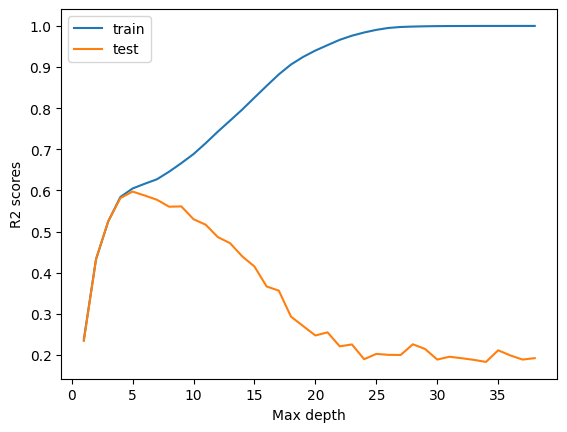

In [87]:
#plot the scores to visually determine the best max_depth
# plt.plot(scores);
plt.plot(depths, scores['Train'], label = 'train')
plt.plot(depths, scores['Test'], label = 'test')
plt.ylabel('R2 scores')
plt.xlabel('Max depth')
plt.legend()
plt.show()

In [88]:
#sort the dataframe by test scores and save the index (k) of the best score
best_depth = scores.sort_values(by='Test', ascending=False).index[0]
best_depth


5

In [89]:
r2_score

<function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', force_finite=True)>

### Fit and Evaluate the best decision tree

In [90]:
# instantiate the best model
best_dec_tree = DecisionTreeRegressor(max_depth=best_depth)

# create pipeline
best_dec_tree_pipe = make_pipeline(preprocessor, best_dec_tree)

# fit the model
best_dec_tree_pipe.fit(X_train, y_train)

# evaluate the model
eval_model(y_train, best_dec_tree_pipe.predict(X_train))
print('Training scores for baseline model')

print('\n')

eval_model(y_test, best_dec_tree_pipe.predict(X_test))
print('Testing scores for baseline model')

 MAE 760.89,
 MSE 1169324.44,
 RMSE: 1081.35,
 R^2: 0.60
Training scores for baseline model


 MAE 743.54,
 MSE 1128384.71,
 RMSE: 1062.25,
 R^2: 0.60
Testing scores for baseline model


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Decision Tree: The r2 in training is at 60% while r2 in testing is at 60%.The delta or the difference between model performance on the training data vs. the test data is zero.

The Decision Tree Regression model is a good fit. There is no gap between the training and testing datasets.

### Create a Summary of the Model Evaluations

In [91]:
# create a dictionary for the models
models = {'Dummy': 'dummy_pipe',
          'Linear Regression': 'lr_pipe',
          'Decision Trees': 'best_dec_tree_pipe'}

# loop for evaluating models on training and testing data
for model_name, pipeline_name in models.items():
  print(f'{model_name} Model:')
  print('Train Evaluation')

  eval_model(y_train, eval(pipeline_name).predict(X_train))
  print('\nTest Evaluation')

  eval_model(y_test, eval(pipeline_name).predict(X_test))
  print('-' * 50)

Dummy Model:
Train Evaluation
 MAE 1356.10,
 MSE 2957434.63,
 RMSE: 1719.72,
 R^2: 0.00

Test Evaluation
 MAE 1338.34,
 MSE 2807178.14,
 RMSE: 1675.46,
 R^2: -0.00
--------------------------------------------------
Linear Regression Model:
Train Evaluation
 MAE 910.62,
 MSE 1457963.16,
 RMSE: 1207.46,
 R^2: 0.51

Test Evaluation
 MAE 876.56,
 MSE 1377129.17,
 RMSE: 1173.51,
 R^2: 0.51
--------------------------------------------------
Decision Trees Model:
Train Evaluation
 MAE 760.89,
 MSE 1169324.44,
 RMSE: 1081.35,
 R^2: 0.60

Test Evaluation
 MAE 743.54,
 MSE 1128384.71,
 RMSE: 1062.25,
 R^2: 0.60
--------------------------------------------------


## Recommendation


The two models (Linear Regression and Decision Tree Model) are good fit but the Decision Tree Model resulted to higher r2 of 61% (where r2 for both training and testing datasets r2 is at 61%)vs. Linear Regression Model (where r2 for both training and testing datasets r2 is at 51%).

Moreover, the Decision Tree Model has lower RMSE or root mean square error (training and testing data have RMSE of 1081 and 1062, respectively). The Linear Regression Model has RMSE of 1207 for the training data, 1173 for the testing data.

Higher r2 and lower RMSE values show that the Decision Tree model makes more accurate predictions and fits the data well. Decision Tree Regression model also beat the baseline. Overall, it is a good fit for our food sales prediction.
